In [18]:

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from captum.attr import LayerIntegratedGradients
import torch




ROBERTA-BASELINE HD less confident instances

In [19]:
from datasets import load_dataset
import pandas as pd





dataset_new = load_dataset(repo_id)


df = pd.DataFrame(dataset_new)

In [20]:
dataset_dict = load_dataset(repo_id)
dataset_split = dataset_dict['train']
df = dataset_split.to_pandas() 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from captum.attr import LayerIntegratedGradients
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import unicodedata
from collections import Counter



nltk.download('stopwords')

#label mapping
labels = ['Pro', 'Against', 'Neutral', 'Not-about']
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/benedetta.muscato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract the 5 examples with the lowest confidence
bottom_examples = df.nsmallest(5, 'confidence_scores')  

#encode inputs
texts = bottom_examples['Input'].tolist()
encoded_inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
example_input_ids = encoded_inputs['input_ids'].to(device)
example_attention_mask = encoded_inputs['attention_mask'].to(device)

In [23]:
#forward model
def model_forward(input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    return probabilities[:, 1]

# Initialize LayerIntegratedGradients
lig = LayerIntegratedGradients(model_forward, model.roberta.embeddings)

# Calculate attributions
attributions, delta = lig.attribute(
    inputs=example_input_ids,
    additional_forward_args=(example_attention_mask,),
    n_steps=50,
    internal_batch_size=8,
    return_convergence_delta=True
)



In [46]:


# Define a list of common adverbs and prepositions
common_adverbs = set([
    'quickly', 'slowly', 'happily', 'sadly', 'easily', 'hardly', 'often', 'never',
    'rarely', 'frequently', 'always', 'mostly', 'just', 'barely', 'simply', 'very', 'ultimately', 'recently', 'moreover', 'towards','despite',
    
])

# Function to clean, lemmatize, and filter tokens
def filter_tokens(tokens, attributions):
    token_freq = Counter(tokens)
    filtered_tokens = []
    filtered_attributions = []
    for token, attr in zip(tokens, attributions):
        token_cleaned = token.replace('Ġ', '')  # Clean token from RoBERTa's special character (Ġ)
        token_cleaned = unicodedata.normalize('NFD', token_cleaned)  # Normalize to remove accents
        
       
        lemmatized_token = lemmatizer.lemmatize(token_cleaned.lower())

        # Filter conditions
        if (lemmatized_token and
            lemmatized_token[0] not in circumflex_accents and
            lemmatized_token not in stop_words and
            lemmatized_token not in punctuation and
            lemmatized_token not in numbers and
            len(lemmatized_token) > 1 and  
            len(lemmatized_token) != 2 and  
            len(lemmatized_token) != 3 and  
            len(lemmatized_token) != 4 and
            len(lemmatized_token) != 5 and
            lemmatized_token != '<\\s>' and  
            token_freq[token] == 1 and  
            lemmatized_token not in common_adverbs):  # Exclude common adverbs
            filtered_tokens.append(lemmatized_token)
            filtered_attributions.append(attr)
    return filtered_tokens, filtered_attributions



attributions_sum = attributions.sum(dim=2).cpu().detach().numpy()
tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in example_input_ids.cpu().numpy()]

# Special tokens and characters to filter out
special_tokens = ['[CLS]', '[SEP]', '[PAD]', '<\\s>']
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
numbers = set(string.digits)
circumflex_accents = set('âêîôû')

# Initial filtering of tokens and attributions (removes special tokens)
filtered_tokens = []
filtered_attributions = []
for i in range(len(tokens)):
    filtered_tokens.append([token for token in tokens[i] if token not in special_tokens])
    filtered_attributions.append([attr for token, attr in zip(tokens[i], attributions_sum[i]) if token not in special_tokens])

# Final token and attribution filtering after cleaning
filtered_tokens_cleaned = []
filtered_attributions_cleaned = []
for i in range(len(filtered_tokens)):
    tokens_cleaned, attributions_cleaned = filter_tokens(filtered_tokens[i], filtered_attributions[i])
    filtered_tokens_cleaned.append(tokens_cleaned)
    filtered_attributions_cleaned.append(attributions_cleaned)

# Getting model outputs and predictions
outputs = model(example_input_ids, attention_mask=example_attention_mask)
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_classes = outputs.logits.argmax(dim=1).cpu().numpy()
predicted_labels = [id2label[id] for id in predicted_classes]


Original Text for Example 1:
Are Social Networking Sites Good for Our Society? Why I abandoned 60,000 followers and deleted my social media - DIY Photography. Nick Fancher, a photographer and author known for his dramatic lighting and minimalistic approach, recently made the radical decision to delete all his social media accounts, which included Instagram, Twitter, and Facebook. This decision came despite his substantial following of over 60,000 across these platforms. Fancher's move, particularly striking for a small business owner, stemmed from a range of personal and professional frustrations with social media.  Fancher’s discontent with social media began to surface prominently during his podcast interviews with various photographers, where discussions often turned to the impact of social media on creativity. In an episode with Italian photographer Sara Lando, the conversation highlighted how social media tends to push creatives towards inauthenticity and encourages producing art 

/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

Original Text for Example 3:
Is Cell Phone Radiation Safe? Attention Required! | Cloudflare. Completing the CAPTCHA proves you are a human and gives you temporary access to the web property.If you are on a personal connection, like at home, you can run an anti-virus scan on your device to make sure it is not infected with malware.If you are at an office or shared network, you can ask the network administrator to run a scan across the network looking for misconfigured or infected devices.Another way to prevent getting this page in the future is to use Privacy Pass. Check out the browser extension in the Chrome Store.


Original Text for Example 4:
Should the Drinking Age Be Lowered from 21 to a Younger Age? Lena Dunham's Comments Defending Jordyn Woods After The Tristan Drama May Surprise You. Amid all the cheating rumors surrounding Jordyn Woods and Tristan Thompson, few people are coming to Woods’ defense. Woods is, after all, Kylie Jenner’s best friend, which places her on the extend

/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')


Original Text for Example 5:
Should the United States Maintain Its Embargo against Cuba? Cuba to UN: End the blockade! – People's World. The Cuban government has recently published a 59-page report detailing the detrimental effects of the U.S. economic blockade on its nation. According to this report, considering inflation, a staggering $933.68 billion has been drained from Cuba's economy since the blockade was initiated, with a loss of $4.3 billion in the most recent year alone. This report precedes the United Nations General Assembly's vote on October 31 on a Cuban resolution to end the blockade, a measure that has been consistently supported by the world community every year since 1992, with the exception of the United States and Israel.  The Cuban report aims to provide comprehensive information to the United Nations delegations and to influence global opinion against the blockade, highlighting it as the main hindrance to Cuba’s economic development. This blockade has led to signif

/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')


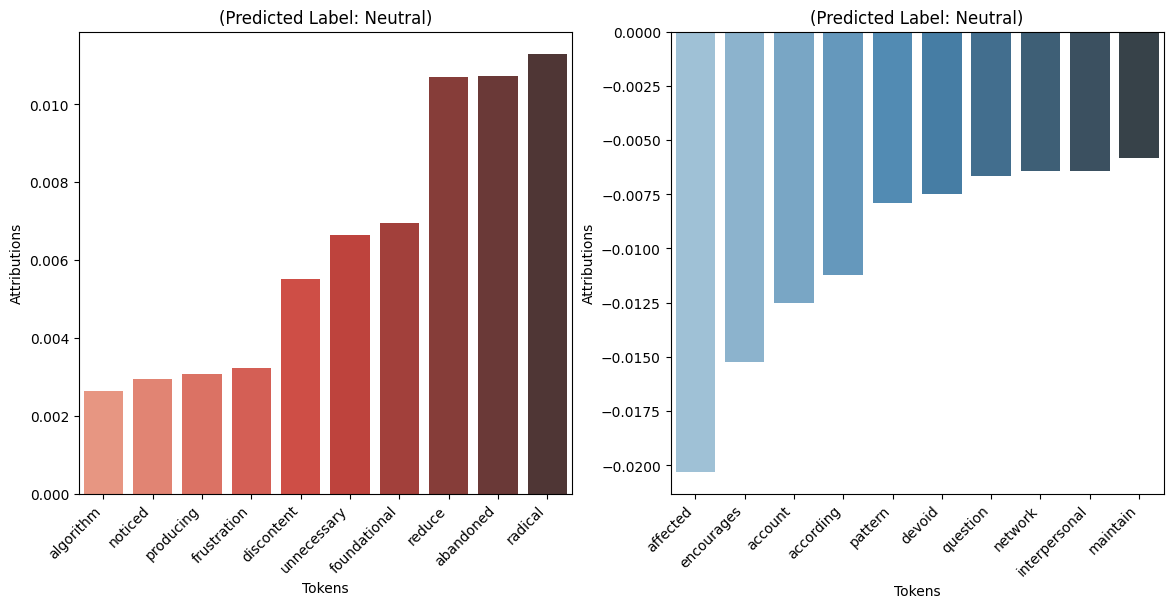

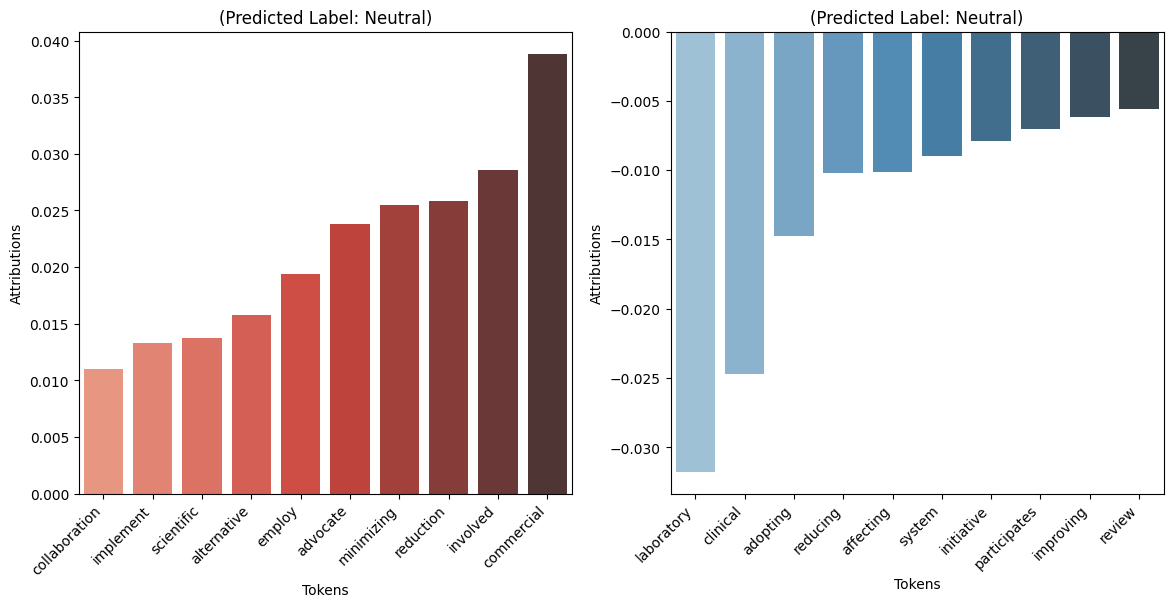

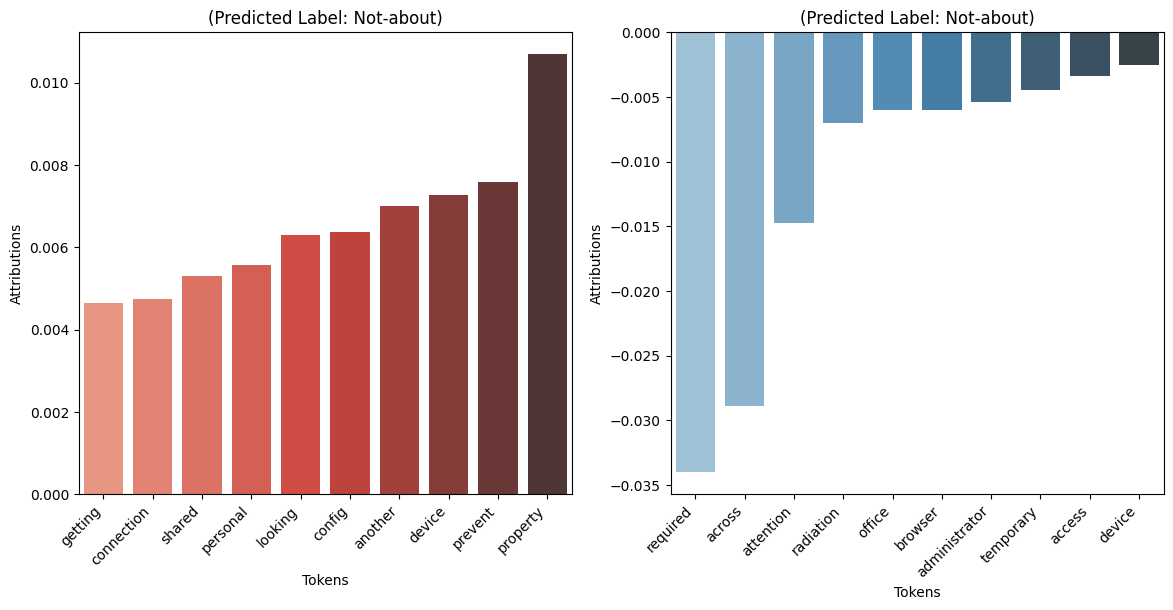

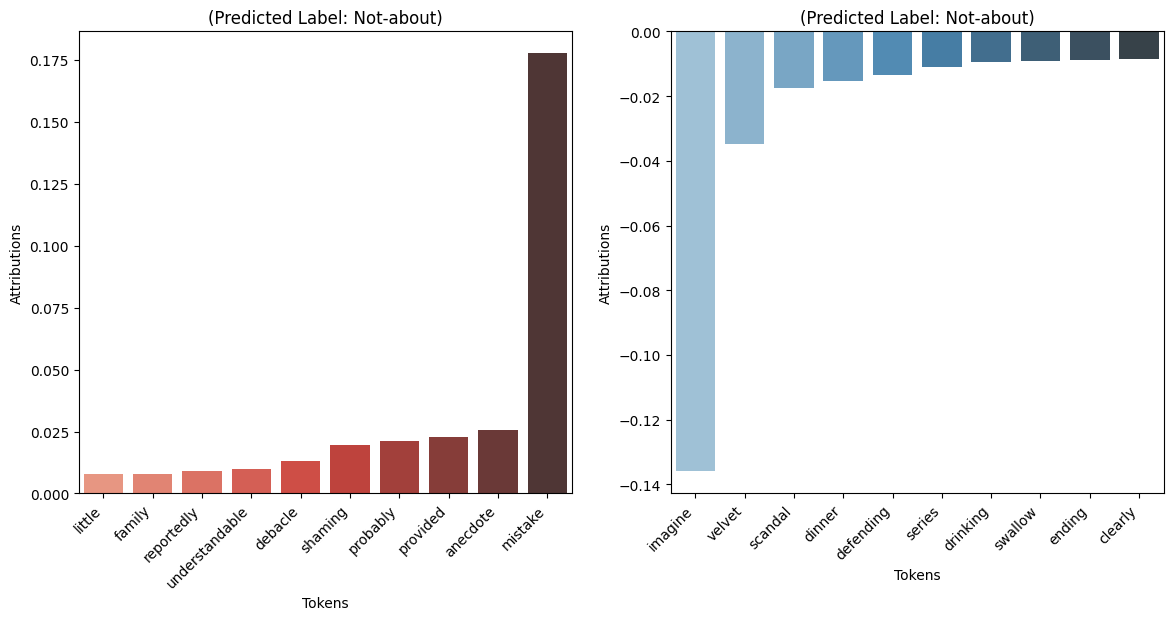

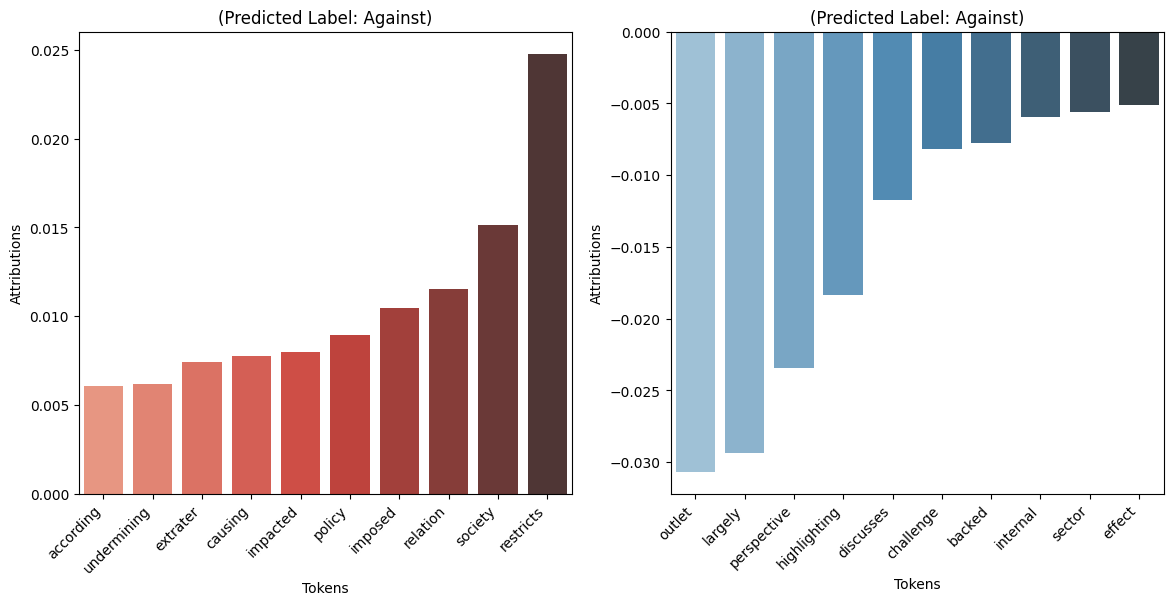

In [47]:
#take first top 10 tokens per relevance 
num_top_tokens = 10
num_bottom_tokens = 10


for i in range(example_input_ids.size(0)):
  
    print(f"Original Text for Example {i+1}:")
    print(bottom_examples['Input'].iloc[i])
    print("\n")
    
    # Get indices of tokens with highest and lowest attributions
    top_indices = np.argsort(filtered_attributions_cleaned[i])[-num_top_tokens:]
    bottom_indices = np.argsort(filtered_attributions_cleaned[i])[:num_bottom_tokens]

    # Select tokens and their corresponding attributions
    top_tokens = [filtered_tokens_cleaned[i][index] for index in top_indices]
    top_attributions = [filtered_attributions_cleaned[i][index] for index in top_indices]
    bottom_tokens = [filtered_tokens_cleaned[i][index] for index in bottom_indices]
    bottom_attributions = [filtered_attributions_cleaned[i][index] for index in bottom_indices]

    
    top_df = pd.DataFrame({
        'Token': top_tokens,
        'Attribution': top_attributions
    })

    bottom_df = pd.DataFrame({
        'Token': bottom_tokens,
        'Attribution': bottom_attributions
    })

   
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
    plt.xlabel('Tokens')
    plt.ylabel('Attributions')
    plt.title(f'(Predicted Label: {predicted_labels[i]})')
    plt.xticks(rotation=45, ha='right')

  
    plt.subplot(1, 2, 2)
    sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
    plt.xlabel('Tokens')
    plt.ylabel('Attributions')
    plt.title(f'(Predicted Label: {predicted_labels[i]})')
    plt.xticks(rotation=45, ha='right')


ROBERTA HD BASELINE MORE CONFIDENT INSTANCES

In [48]:
up_examples = df.nlargest(5, 'confidence_scores')  


texts = up_examples['Input'].tolist()
encoded_inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
example_input_ids = encoded_inputs['input_ids'].to(device)
example_attention_mask = encoded_inputs['attention_mask'].to(device)

# Define the model forward function
def model_forward(input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    return probabilities[:, 1]

# Initialize LayerIntegratedGradients
lig = LayerIntegratedGradients(model_forward, model.roberta.embeddings)

# Calculate attributions
attributions, delta = lig.attribute(
    inputs=example_input_ids,
    additional_forward_args=(example_attention_mask,),
    n_steps=50,
    internal_batch_size=4,
    return_convergence_delta=True
)

/home/benedetta.muscato/multiperspective/multip/lib/python3.10/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 5 equal to the number of examples.
  warnings.warn(


In [55]:



common_adverbs = set([
    'quickly', 'slowly', 'happily', 'sadly', 'easily', 'hardly', 'often', 'never',
    'rarely', 'frequently', 'always', 'mostly', 'just', 'barely', 'simply', 'very', 'ultimately', 'recently', 'moreover', 'towards','despite', 'additionally', 'including', 'regularly',
    
])

# Function to clean, lemmatize, and filter tokens
def filter_tokens(tokens, attributions):
    token_freq = Counter(tokens)
    filtered_tokens = []
    filtered_attributions = []
    for token, attr in zip(tokens, attributions):
        token_cleaned = token.replace('Ġ', '')  # Clean token from RoBERTa's special character (Ġ)
        token_cleaned = unicodedata.normalize('NFD', token_cleaned)  # Normalize to remove accents
        
        # Lemmatize the cleaned token
        lemmatized_token = lemmatizer.lemmatize(token_cleaned.lower())

        # Filter conditions
        if (lemmatized_token and
            lemmatized_token[0] not in circumflex_accents and
            lemmatized_token not in stop_words and
            lemmatized_token not in punctuation and
            lemmatized_token not in numbers and
            len(lemmatized_token) > 1 and  
            len(lemmatized_token) != 2 and 
            len(lemmatized_token) != 3 and 
            len(lemmatized_token) != 4 and
            len(lemmatized_token) != 5 and
            lemmatized_token != '<\\s>' and 
            token_freq[token] == 1 and  
            lemmatized_token not in common_adverbs):  
            filtered_tokens.append(lemmatized_token)
            filtered_attributions.append(attr)
    return filtered_tokens, filtered_attributions


# Convert attributions to a list of values for tokens
attributions_sum = attributions.sum(dim=2).cpu().detach().numpy()
tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in example_input_ids.cpu().numpy()]

# Special tokens and characters to filter out
special_tokens = ['[CLS]', '[SEP]', '[PAD]', '<\\s>']
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
numbers = set(string.digits)
circumflex_accents = set('âêîôû')

# Initial filtering of tokens and attributions (removes special tokens)
filtered_tokens = []
filtered_attributions = []
for i in range(len(tokens)):
    filtered_tokens.append([token for token in tokens[i] if token not in special_tokens])
    filtered_attributions.append([attr for token, attr in zip(tokens[i], attributions_sum[i]) if token not in special_tokens])

# Final token and attribution filtering after cleaning
filtered_tokens_cleaned = []
filtered_attributions_cleaned = []
for i in range(len(filtered_tokens)):
    tokens_cleaned, attributions_cleaned = filter_tokens(filtered_tokens[i], filtered_attributions[i])
    filtered_tokens_cleaned.append(tokens_cleaned)
    filtered_attributions_cleaned.append(attributions_cleaned)

# Getting model outputs and predictions
outputs = model(example_input_ids, attention_mask=example_attention_mask)
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_classes = outputs.logits.argmax(dim=1).cpu().numpy()
predicted_labels = [id2label[id] for id in predicted_classes]


Original Text for Example 1:
Are Social Networking Sites Good for Our Society? Why I abandoned 60,000 followers and deleted my social media - DIY Photography. Nick Fancher, a photographer and author known for his dramatic lighting and minimalistic approach, recently made the radical decision to delete all his social media accounts, which included Instagram, Twitter, and Facebook. This decision came despite his substantial following of over 60,000 across these platforms. Fancher's move, particularly striking for a small business owner, stemmed from a range of personal and professional frustrations with social media.  Fancher’s discontent with social media began to surface prominently during his podcast interviews with various photographers, where discussions often turned to the impact of social media on creativity. In an episode with Italian photographer Sara Lando, the conversation highlighted how social media tends to push creatives towards inauthenticity and encourages producing art 

/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

Original Text for Example 3:
Is Cell Phone Radiation Safe? Attention Required! | Cloudflare. Completing the CAPTCHA proves you are a human and gives you temporary access to the web property.If you are on a personal connection, like at home, you can run an anti-virus scan on your device to make sure it is not infected with malware.If you are at an office or shared network, you can ask the network administrator to run a scan across the network looking for misconfigured or infected devices.Another way to prevent getting this page in the future is to use Privacy Pass. Check out the browser extension in the Chrome Store.


Original Text for Example 4:
Should the Drinking Age Be Lowered from 21 to a Younger Age? Lena Dunham's Comments Defending Jordyn Woods After The Tristan Drama May Surprise You. Amid all the cheating rumors surrounding Jordyn Woods and Tristan Thompson, few people are coming to Woods’ defense. Woods is, after all, Kylie Jenner’s best friend, which places her on the extend

/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')


Original Text for Example 5:
Should the United States Maintain Its Embargo against Cuba? Cuba to UN: End the blockade! – People's World. The Cuban government has recently published a 59-page report detailing the detrimental effects of the U.S. economic blockade on its nation. According to this report, considering inflation, a staggering $933.68 billion has been drained from Cuba's economy since the blockade was initiated, with a loss of $4.3 billion in the most recent year alone. This report precedes the United Nations General Assembly's vote on October 31 on a Cuban resolution to end the blockade, a measure that has been consistently supported by the world community every year since 1992, with the exception of the United States and Israel.  The Cuban report aims to provide comprehensive information to the United Nations delegations and to influence global opinion against the blockade, highlighting it as the main hindrance to Cuba’s economic development. This blockade has led to signif

/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')


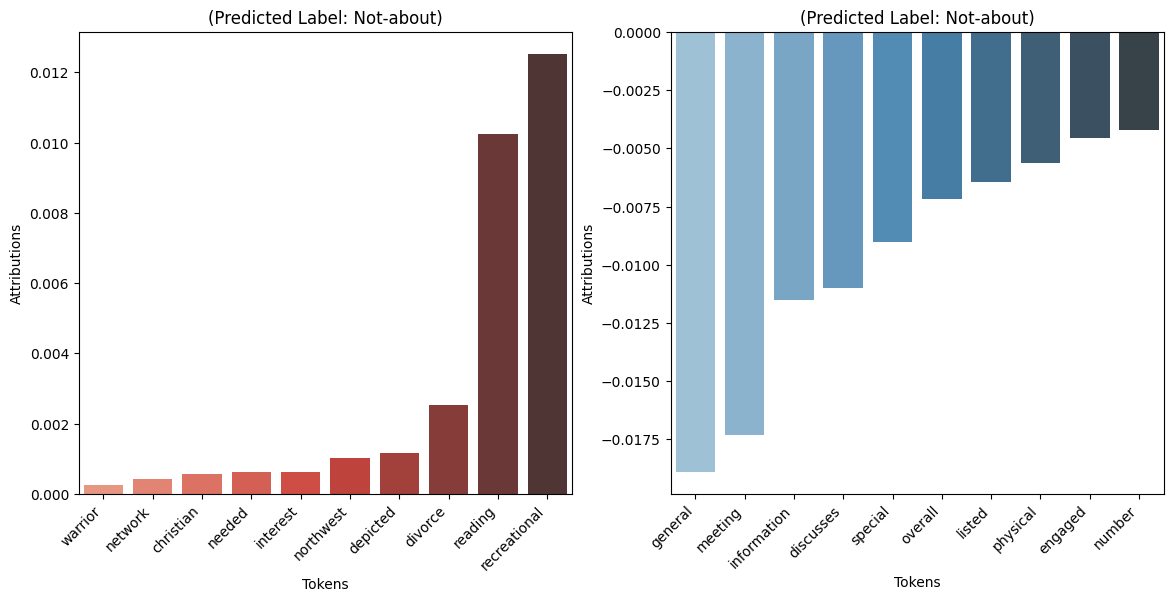

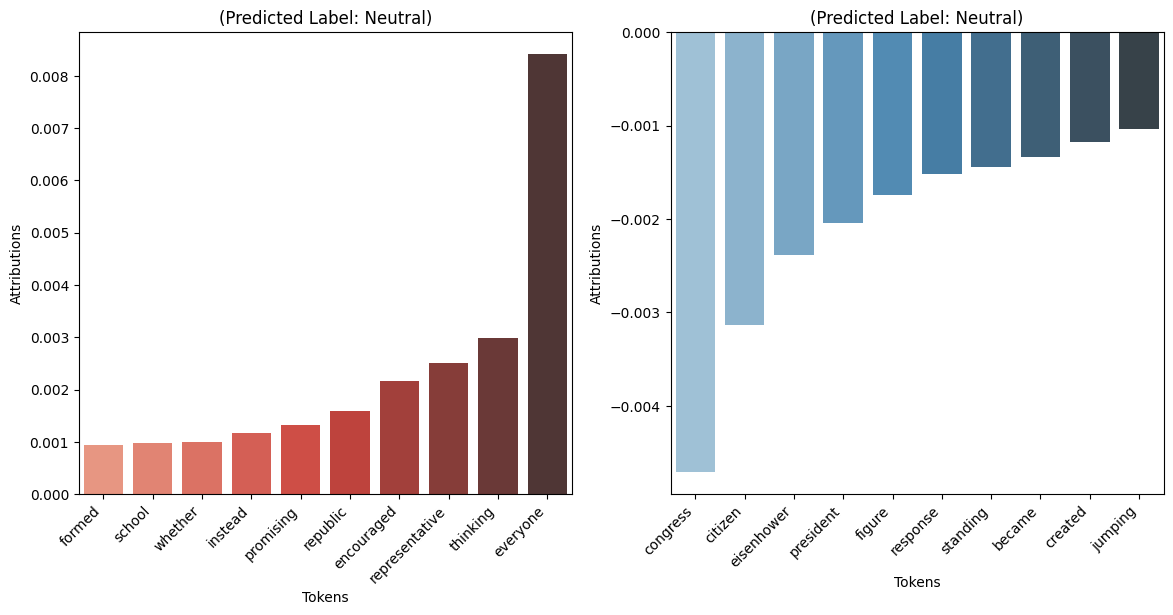

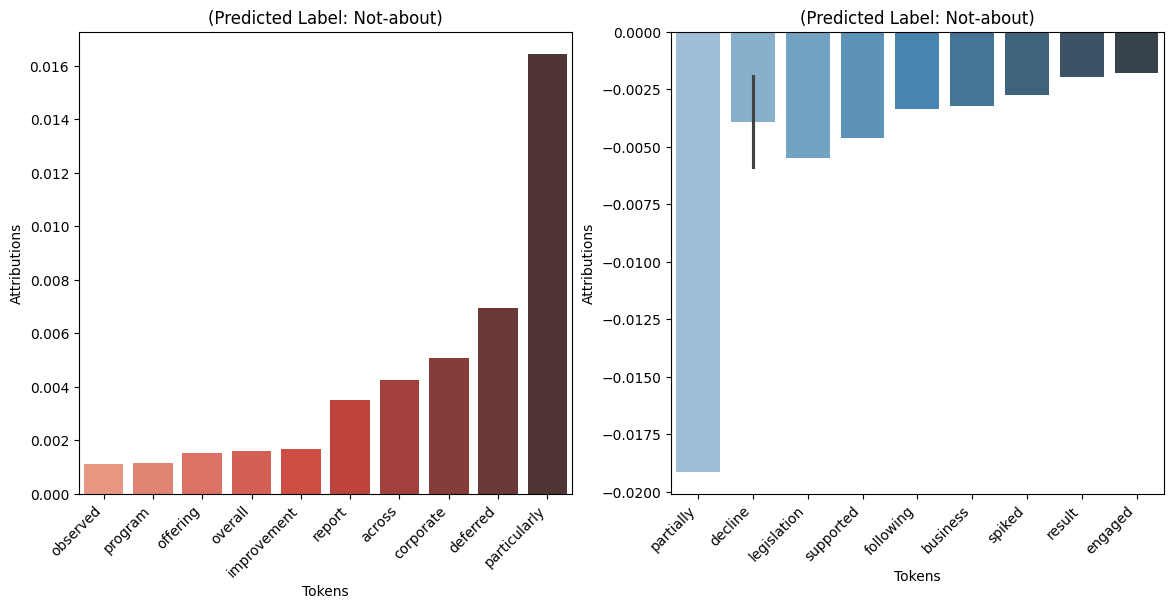

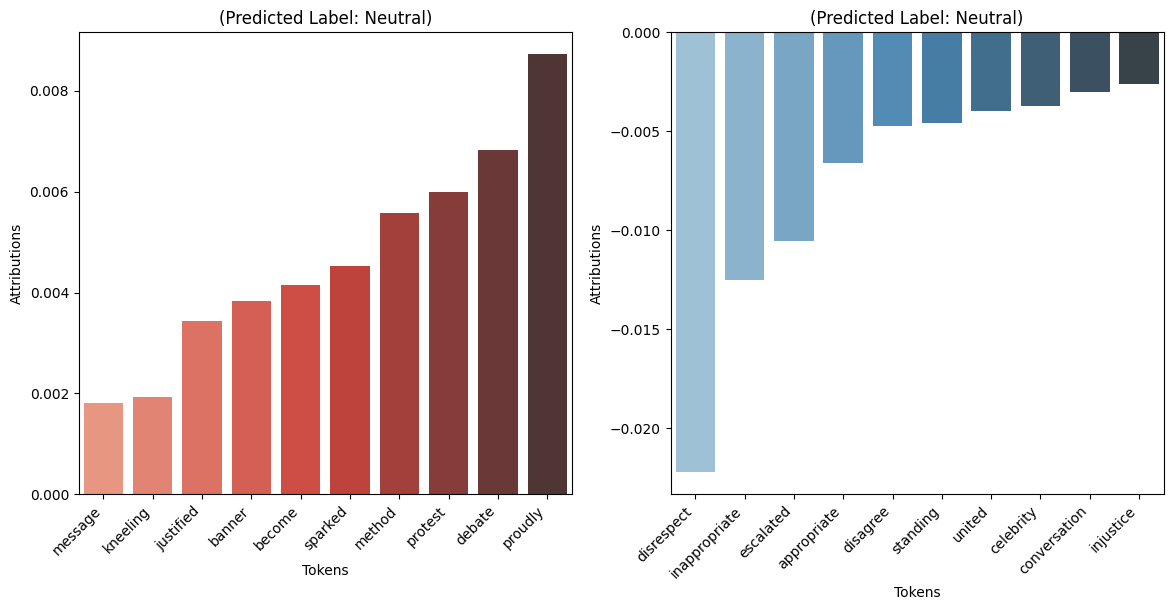

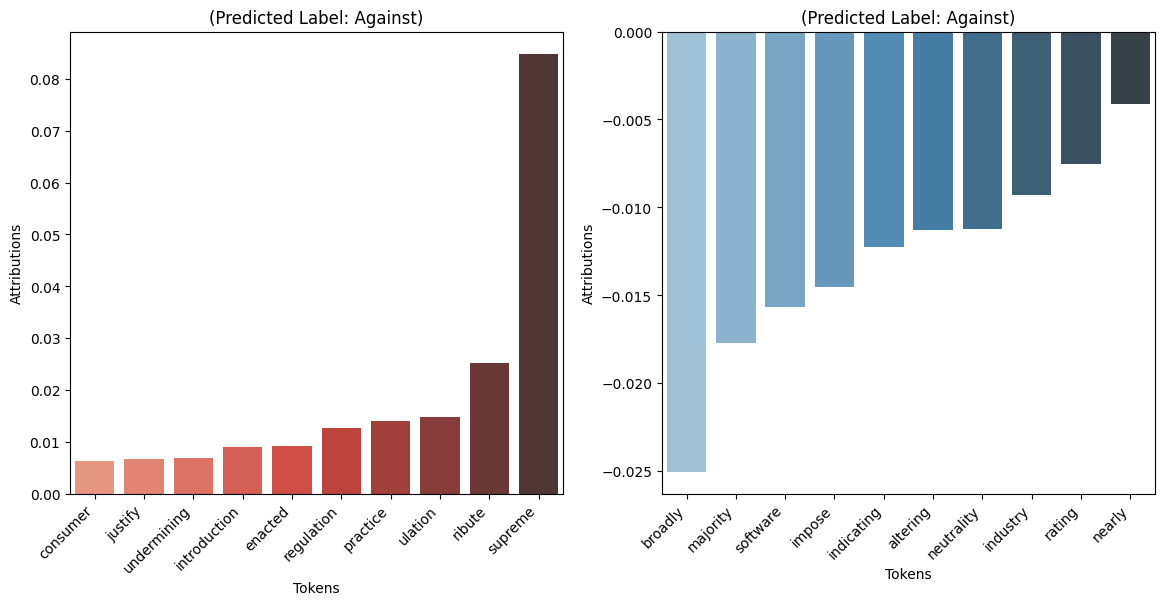

In [56]:
num_top_tokens = 10
num_bottom_tokens = 10


for i in range(example_input_ids.size(0)):
   
    print(f"Original Text for Example {i+1}:")
    print(bottom_examples['Input'].iloc[i])
    print("\n")
    
    # Get indices of tokens with highest and lowest attributions
    top_indices = np.argsort(filtered_attributions_cleaned[i])[-num_top_tokens:]
    bottom_indices = np.argsort(filtered_attributions_cleaned[i])[:num_bottom_tokens]

    # Select tokens and their corresponding attributions
    top_tokens = [filtered_tokens_cleaned[i][index] for index in top_indices]
    top_attributions = [filtered_attributions_cleaned[i][index] for index in top_indices]
    bottom_tokens = [filtered_tokens_cleaned[i][index] for index in bottom_indices]
    bottom_attributions = [filtered_attributions_cleaned[i][index] for index in bottom_indices]

    
    top_df = pd.DataFrame({
        'Token': top_tokens,
        'Attribution': top_attributions
    })

    bottom_df = pd.DataFrame({
        'Token': bottom_tokens,
        'Attribution': bottom_attributions
    })

   
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
    plt.xlabel('Tokens')
    plt.ylabel('Attributions')
    plt.title(f'(Predicted Label: {predicted_labels[i]})')
    plt.xticks(rotation=45, ha='right')

  
    plt.subplot(1, 2, 2)
    sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
    plt.xlabel('Tokens')
    plt.ylabel('Attributions')
    plt.title(f'(Predicted Label: {predicted_labels[i]})')
    plt.xticks(rotation=45, ha='right')


RoBERTa-Multi-Perspective HD  less confident instances 

In [57]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from captum.attr import LayerIntegratedGradients
import torch




In [58]:
from datasets import load_dataset
import pandas as pd




dataset = load_dataset(repo_id)


df_multip = pd.DataFrame(dataset)

In [59]:
dataset_dict = load_dataset(repo_id_multip)
dataset_split = dataset_dict['train']
df_multip = dataset_split.to_pandas() 

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract the 5 examples with the lowest confidence
bottom_examples = df_multip.nsmallest(5, 'confidence_scores')  


texts = bottom_examples['Input'].tolist()
encoded_inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
example_input_ids = encoded_inputs['input_ids'].to(device)
example_attention_mask = encoded_inputs['attention_mask'].to(device)

In [61]:
#forward model
def model_forward(input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    return probabilities[:, 1]

# Initialize LayerIntegratedGradients
lig = LayerIntegratedGradients(model_forward, model.roberta.embeddings)

# Calculate attributions
attributions, delta = lig.attribute(
    inputs=example_input_ids,
    additional_forward_args=(example_attention_mask,),
    n_steps=50,
    internal_batch_size=4,
    return_convergence_delta=True
)


/home/benedetta.muscato/multiperspective/multip/lib/python3.10/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 5 equal to the number of examples.
  warnings.warn(


In [64]:



common_adverbs = set([
    'quickly', 'slowly', 'happily', 'sadly', 'easily', 'hardly', 'often', 'never',
    'rarely', 'frequently', 'always', 'mostly', 'just', 'barely', 'simply', 'very', 'ultimately', 'recently', 'moreover', 'towards','despite', 'particularly',
    
])

# Function to clean, lemmatize, and filter tokens
def filter_tokens(tokens, attributions):
    token_freq = Counter(tokens)
    filtered_tokens = []
    filtered_attributions = []
    for token, attr in zip(tokens, attributions):
        token_cleaned = token.replace('Ġ', '')  # Clean token from RoBERTa's special character (Ġ)
        token_cleaned = unicodedata.normalize('NFD', token_cleaned)  # Normalize to remove accents
        
       
        lemmatized_token = lemmatizer.lemmatize(token_cleaned.lower())

        # Filter conditions
        if (lemmatized_token and
            lemmatized_token[0] not in circumflex_accents and
            lemmatized_token not in stop_words and
            lemmatized_token not in punctuation and
            lemmatized_token not in numbers and
            len(lemmatized_token) > 1 and  
            len(lemmatized_token) != 2 and  
            len(lemmatized_token) != 3 and  
            len(lemmatized_token) != 4 and
            len(lemmatized_token) != 5 and
            lemmatized_token != '<\\s>' and  
            token_freq[token] == 1 and  
            lemmatized_token not in common_adverbs):  
            filtered_tokens.append(lemmatized_token)
            filtered_attributions.append(attr)
    return filtered_tokens, filtered_attributions


# Convert attributions to a list of values for tokens
attributions_sum = attributions.sum(dim=2).cpu().detach().numpy()
tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in example_input_ids.cpu().numpy()]

# Special tokens and characters to filter out
special_tokens = ['[CLS]', '[SEP]', '[PAD]', '<\\s>']
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
numbers = set(string.digits)
circumflex_accents = set('âêîôû')

# Initial filtering of tokens and attributions (removes special tokens)
filtered_tokens = []
filtered_attributions = []
for i in range(len(tokens)):
    filtered_tokens.append([token for token in tokens[i] if token not in special_tokens])
    filtered_attributions.append([attr for token, attr in zip(tokens[i], attributions_sum[i]) if token not in special_tokens])

# Final token and attribution filtering after cleaning
filtered_tokens_cleaned = []
filtered_attributions_cleaned = []
for i in range(len(filtered_tokens)):
    tokens_cleaned, attributions_cleaned = filter_tokens(filtered_tokens[i], filtered_attributions[i])
    filtered_tokens_cleaned.append(tokens_cleaned)
    filtered_attributions_cleaned.append(attributions_cleaned)

# Getting model outputs and predictions
outputs = model(example_input_ids, attention_mask=example_attention_mask)
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_classes = outputs.logits.argmax(dim=1).cpu().numpy()
predicted_labels = [id2label[id] for id in predicted_classes]


Original Text for Example 1:
Should Animals Be Used for Scientific or Commercial Testing? 3Rs of Animal Testing for Regenerative Medicine Products | Science Translational Medicine. The use of animals in scientific and commercial testing, particularly for Regenerative Medicine (RM) products, is subject to stringent regulations by the U.S. Food and Drug Administration (FDA) to ensure animal welfare and scientific integrity. The FDA adheres to the 3Rs—reduce, refine, replace—a set of principles aimed at minimizing the use of animals in preclinical studies. These principles are critical for evaluating the safety and effectiveness of RM products, which are used to treat a variety of diseases and injuries.  The 3Rs are defined as follows:  1. Reduction - employing methods that decrease the number of animals used in experiments without affecting the quality of the data, 2. Refinement - improving conditions and procedures to minimize distress and enhance well-being of the animals used, 3. Repl

/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

Original Text for Example 3:
Should the United States Continue Its Use of Drone Strikes Abroad? US Withdrawal from, and Russia’s Suspension of, the INF Treaty: The Implications for Nigeria. The text revolves around the controversies and the diverging paths the United States and Russia have taken regarding the Intermediate-Range Nuclear Forces (INF) Treaty, its implications for global security, and specifically how it could impact Nigeria and broader African geopolitical strategies.  The INF Treaty, signed in 1987 between the U.S. and the USSR, played a pivotal role in eliminating intermediate-range and shorter-range missiles and ensuring a nuclear missile-free Europe. Both countries engaged significantly in dismantling their arsenals in adherence to the treaty's terms, which represented an important move towards reducing the nuclear threat at the time.  However, recent developments have created tensions and uncertainty about the future of nuclear disarmament. In February 2019, the U.S.

/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')


Original Text for Example 5:
Should Gay Marriage Be Legal? Editorial: Anti-gay legislation not what level-headed Kansas is about - Opinion - The Garden City Telegram - Garden City, KS. AdvertisementSubscribe to The Garden City TelegramWe’d like to take up this space today to send a message to friends and family members who live out of state. And to some of the people who drop in on Kansas news occasionally for whatever reason.Here’s the basic point: The extremists who introduced the anti-gay measures in the Kansas Legislature this week don’t represent what Kansas is all about. Their efforts are sure to fail, because the rest of the Legislature and the governor are more level-headed. That’s the real Kansas.The bill we’re talking about is an attempt to end the government’s recognition of same-sex marriage. The text of the bill includes this: “The government’s endorsement of LGBTQ ideology has amounted to the greatest sham since the inception of American jurisprudence.” It goes on to say 

/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')


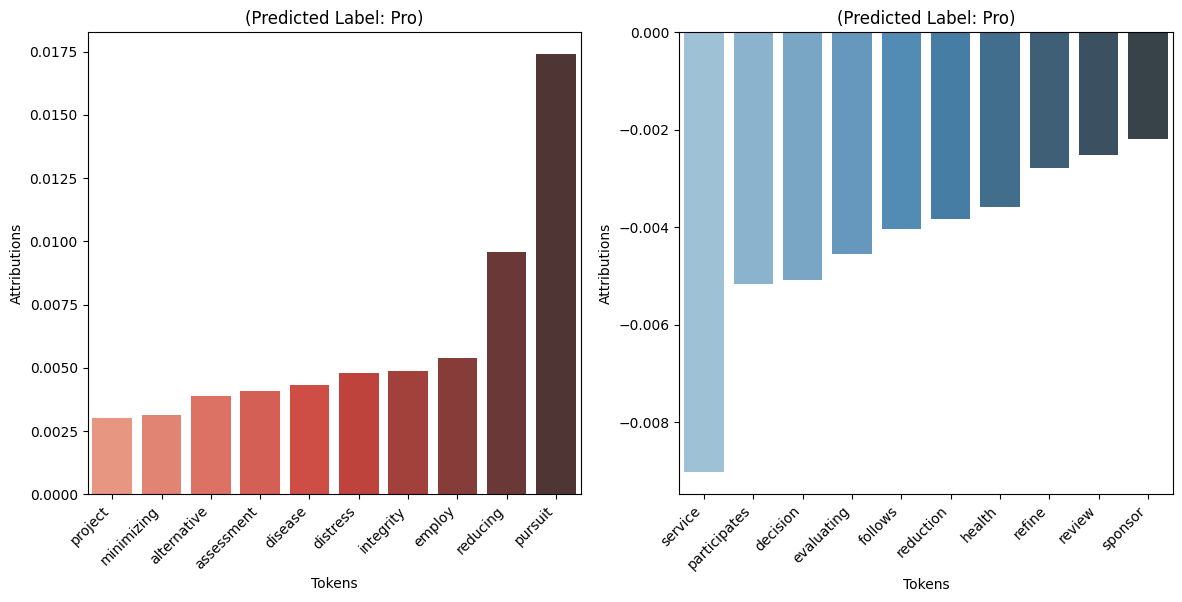

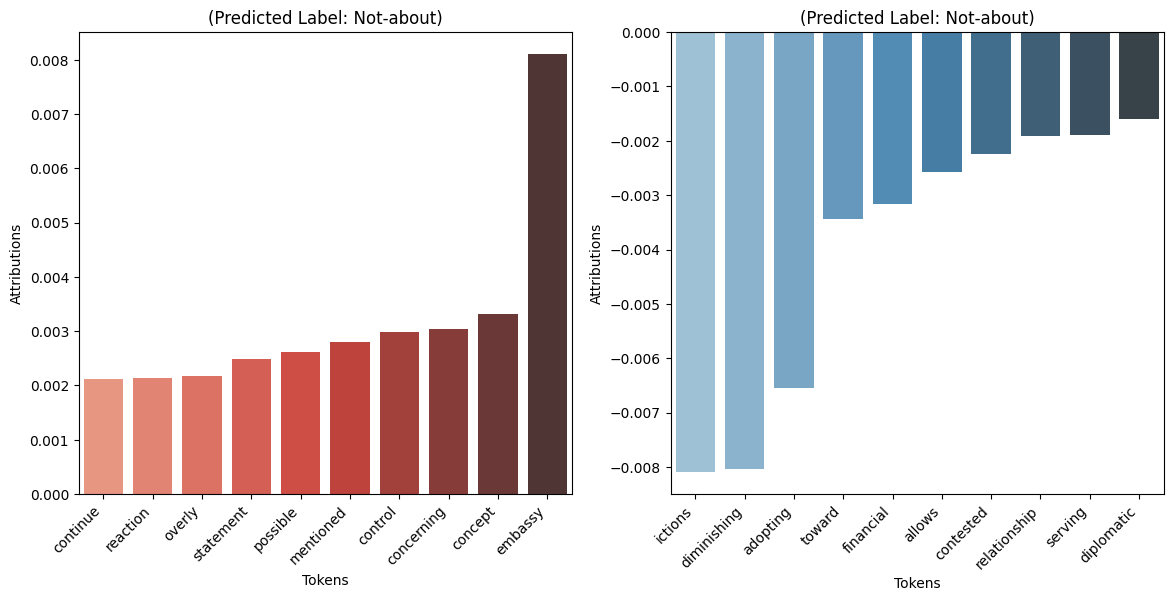

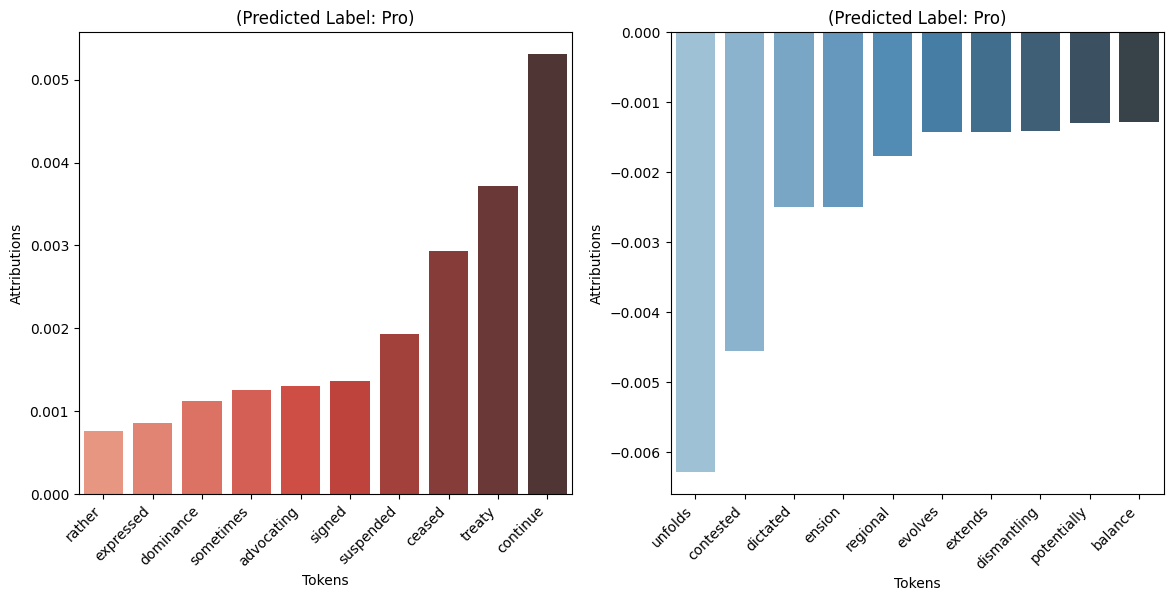

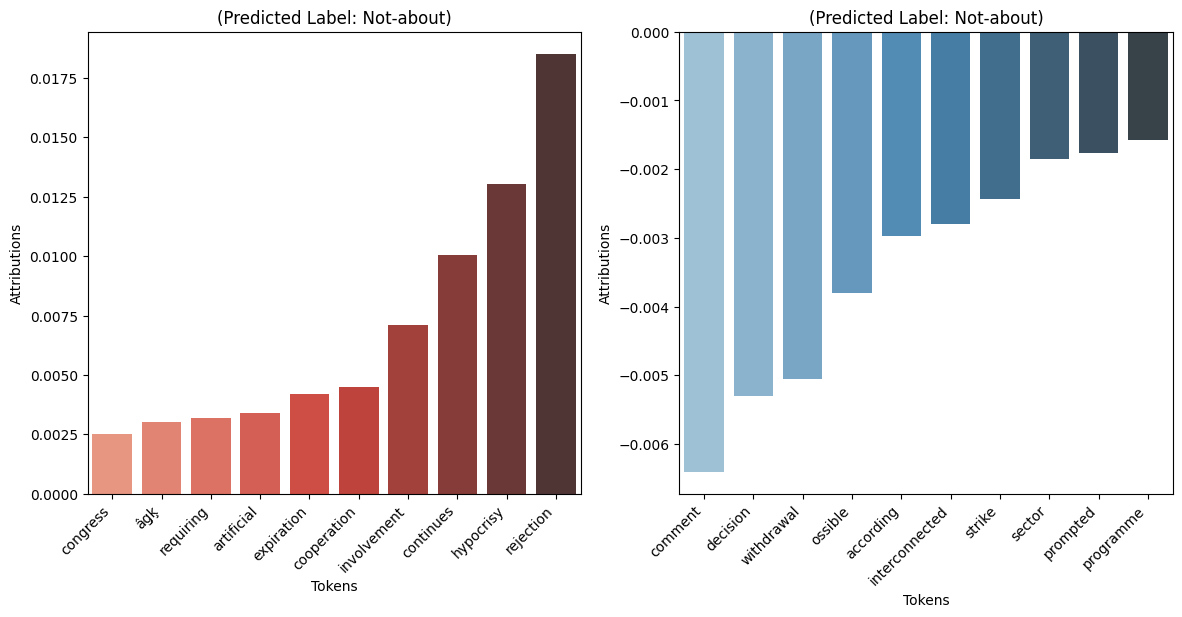

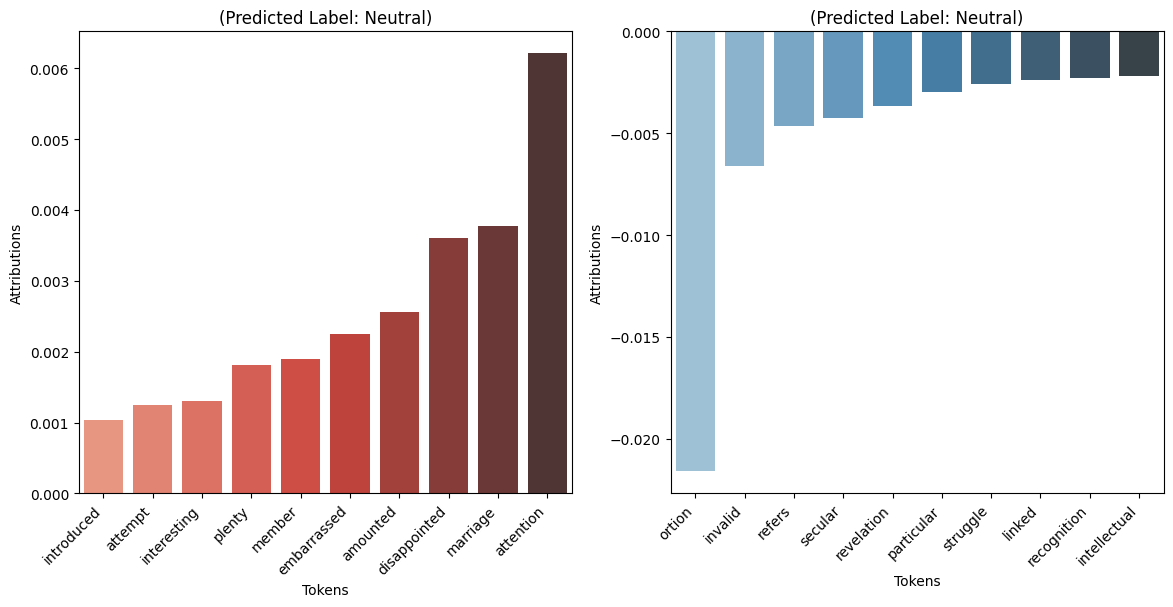

In [65]:
num_top_tokens = 10
num_bottom_tokens = 10


for i in range(example_input_ids.size(0)):

    print(f"Original Text for Example {i+1}:")
    print(bottom_examples['Input'].iloc[i])
    print("\n")
    
    # Get indices of tokens with highest and lowest attributions
    top_indices = np.argsort(filtered_attributions_cleaned[i])[-num_top_tokens:]
    bottom_indices = np.argsort(filtered_attributions_cleaned[i])[:num_bottom_tokens]

    # Select tokens and their corresponding attributions
    top_tokens = [filtered_tokens_cleaned[i][index] for index in top_indices]
    top_attributions = [filtered_attributions_cleaned[i][index] for index in top_indices]
    bottom_tokens = [filtered_tokens_cleaned[i][index] for index in bottom_indices]
    bottom_attributions = [filtered_attributions_cleaned[i][index] for index in bottom_indices]

    
    top_df = pd.DataFrame({
        'Token': top_tokens,
        'Attribution': top_attributions
    })

    bottom_df = pd.DataFrame({
        'Token': bottom_tokens,
        'Attribution': bottom_attributions
    })

   
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
    plt.xlabel('Tokens')
    plt.ylabel('Attributions')
    plt.title(f'(Predicted Label: {predicted_labels[i]})')
    plt.xticks(rotation=45, ha='right')

  
    plt.subplot(1, 2, 2)
    sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
    plt.xlabel('Tokens')
    plt.ylabel('Attributions')
    plt.title(f'(Predicted Label: {predicted_labels[i]})')
    plt.xticks(rotation=45, ha='right')


RoBERTa-Multi-Perspective HD more confident instances

In [66]:
up_examples = df_multip.nlargest(5, 'confidence_scores') 


texts = up_examples['Input'].tolist()
encoded_inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
example_input_ids = encoded_inputs['input_ids'].to(device)
example_attention_mask = encoded_inputs['attention_mask'].to(device)

# Define the model forward function
def model_forward(input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    return probabilities[:, 1]

# Initialize LayerIntegratedGradients
lig = LayerIntegratedGradients(model_forward, model.roberta.embeddings)

# Calculate attributions
attributions, delta = lig.attribute(
    inputs=example_input_ids,
    additional_forward_args=(example_attention_mask,),
    n_steps=50,
    internal_batch_size=4,
    return_convergence_delta=True
)

/home/benedetta.muscato/multiperspective/multip/lib/python3.10/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 5 equal to the number of examples.
  warnings.warn(


In [69]:



common_adverbs = set([
    'quickly', 'slowly', 'happily', 'sadly', 'easily', 'hardly', 'often', 'never',
    'rarely', 'frequently', 'always', 'mostly', 'just', 'barely', 'simply', 'very', 'ultimately', 'recently', 'moreover', 'towards','despite', 'particularly', 'proudly'
    
])

# Function to clean, lemmatize, and filter tokens
def filter_tokens(tokens, attributions):
    token_freq = Counter(tokens)
    filtered_tokens = []
    filtered_attributions = []
    for token, attr in zip(tokens, attributions):
        token_cleaned = token.replace('Ġ', '')  # Clean token from RoBERTa's special character (Ġ)
        token_cleaned = unicodedata.normalize('NFD', token_cleaned)  # Normalize to remove accents
        
     
        lemmatized_token = lemmatizer.lemmatize(token_cleaned.lower())

        # Filter conditions
        if (lemmatized_token and
            lemmatized_token[0] not in circumflex_accents and
            lemmatized_token not in stop_words and
            lemmatized_token not in punctuation and
            lemmatized_token not in numbers and
            len(lemmatized_token) > 1 and  
            len(lemmatized_token) != 2 and 
            len(lemmatized_token) != 3 and 
            len(lemmatized_token) != 4 and
            len(lemmatized_token) != 5 and
            lemmatized_token != '<\\s>' and  
            token_freq[token] == 1 and  
            lemmatized_token not in common_adverbs):  
            filtered_tokens.append(lemmatized_token)
            filtered_attributions.append(attr)
    return filtered_tokens, filtered_attributions


# Convert attributions to a list of values for tokens
attributions_sum = attributions.sum(dim=2).cpu().detach().numpy()
tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in example_input_ids.cpu().numpy()]

# Special tokens and characters to filter out
special_tokens = ['[CLS]', '[SEP]', '[PAD]', '<\\s>']
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
numbers = set(string.digits)
circumflex_accents = set('âêîôû')

# Initial filtering of tokens and attributions (removes special tokens)
filtered_tokens = []
filtered_attributions = []
for i in range(len(tokens)):
    filtered_tokens.append([token for token in tokens[i] if token not in special_tokens])
    filtered_attributions.append([attr for token, attr in zip(tokens[i], attributions_sum[i]) if token not in special_tokens])

# Final token and attribution filtering after cleaning
filtered_tokens_cleaned = []
filtered_attributions_cleaned = []
for i in range(len(filtered_tokens)):
    tokens_cleaned, attributions_cleaned = filter_tokens(filtered_tokens[i], filtered_attributions[i])
    filtered_tokens_cleaned.append(tokens_cleaned)
    filtered_attributions_cleaned.append(attributions_cleaned)

# Getting model outputs and predictions
outputs = model(example_input_ids, attention_mask=example_attention_mask)
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_classes = outputs.logits.argmax(dim=1).cpu().numpy()
predicted_labels = [id2label[id] for id in predicted_classes]


Original Text for Example 1:
Should Animals Be Used for Scientific or Commercial Testing? 3Rs of Animal Testing for Regenerative Medicine Products | Science Translational Medicine. The use of animals in scientific and commercial testing, particularly for Regenerative Medicine (RM) products, is subject to stringent regulations by the U.S. Food and Drug Administration (FDA) to ensure animal welfare and scientific integrity. The FDA adheres to the 3Rs—reduce, refine, replace—a set of principles aimed at minimizing the use of animals in preclinical studies. These principles are critical for evaluating the safety and effectiveness of RM products, which are used to treat a variety of diseases and injuries.  The 3Rs are defined as follows:  1. Reduction - employing methods that decrease the number of animals used in experiments without affecting the quality of the data, 2. Refinement - improving conditions and procedures to minimize distress and enhance well-being of the animals used, 3. Repl

/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

Original Text for Example 3:
Should the United States Continue Its Use of Drone Strikes Abroad? US Withdrawal from, and Russia’s Suspension of, the INF Treaty: The Implications for Nigeria. The text revolves around the controversies and the diverging paths the United States and Russia have taken regarding the Intermediate-Range Nuclear Forces (INF) Treaty, its implications for global security, and specifically how it could impact Nigeria and broader African geopolitical strategies.  The INF Treaty, signed in 1987 between the U.S. and the USSR, played a pivotal role in eliminating intermediate-range and shorter-range missiles and ensuring a nuclear missile-free Europe. Both countries engaged significantly in dismantling their arsenals in adherence to the treaty's terms, which represented an important move towards reducing the nuclear threat at the time.  However, recent developments have created tensions and uncertainty about the future of nuclear disarmament. In February 2019, the U.S.

/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
/tmp/ipykernel_2706979/476346174.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')


Original Text for Example 5:
Should Gay Marriage Be Legal? Editorial: Anti-gay legislation not what level-headed Kansas is about - Opinion - The Garden City Telegram - Garden City, KS. AdvertisementSubscribe to The Garden City TelegramWe’d like to take up this space today to send a message to friends and family members who live out of state. And to some of the people who drop in on Kansas news occasionally for whatever reason.Here’s the basic point: The extremists who introduced the anti-gay measures in the Kansas Legislature this week don’t represent what Kansas is all about. Their efforts are sure to fail, because the rest of the Legislature and the governor are more level-headed. That’s the real Kansas.The bill we’re talking about is an attempt to end the government’s recognition of same-sex marriage. The text of the bill includes this: “The government’s endorsement of LGBTQ ideology has amounted to the greatest sham since the inception of American jurisprudence.” It goes on to say 

/tmp/ipykernel_2706979/476346174.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')


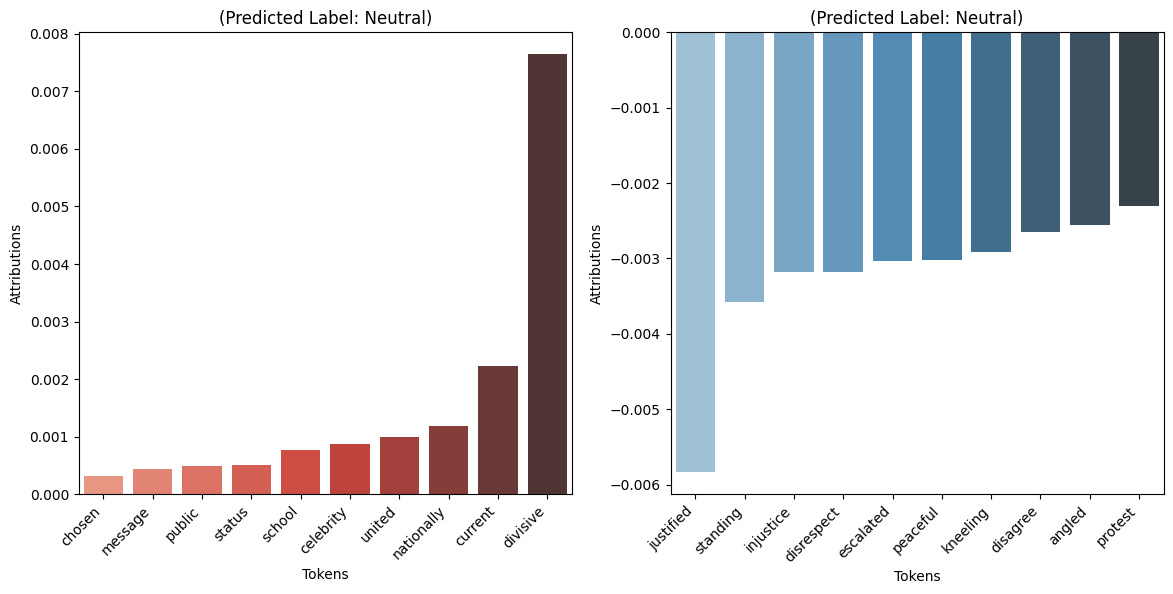

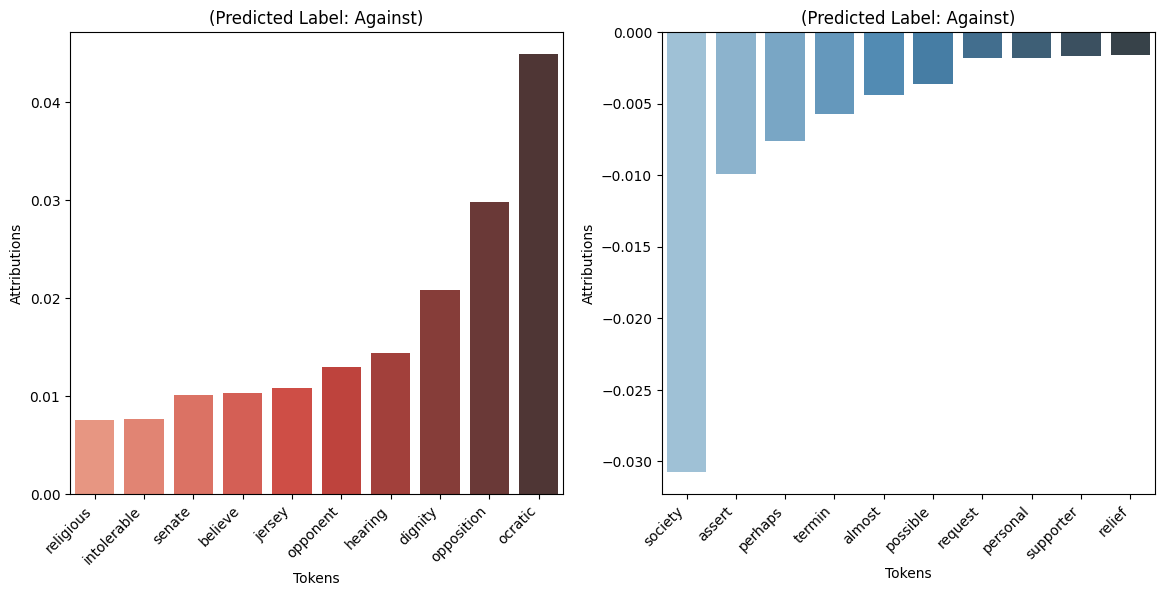

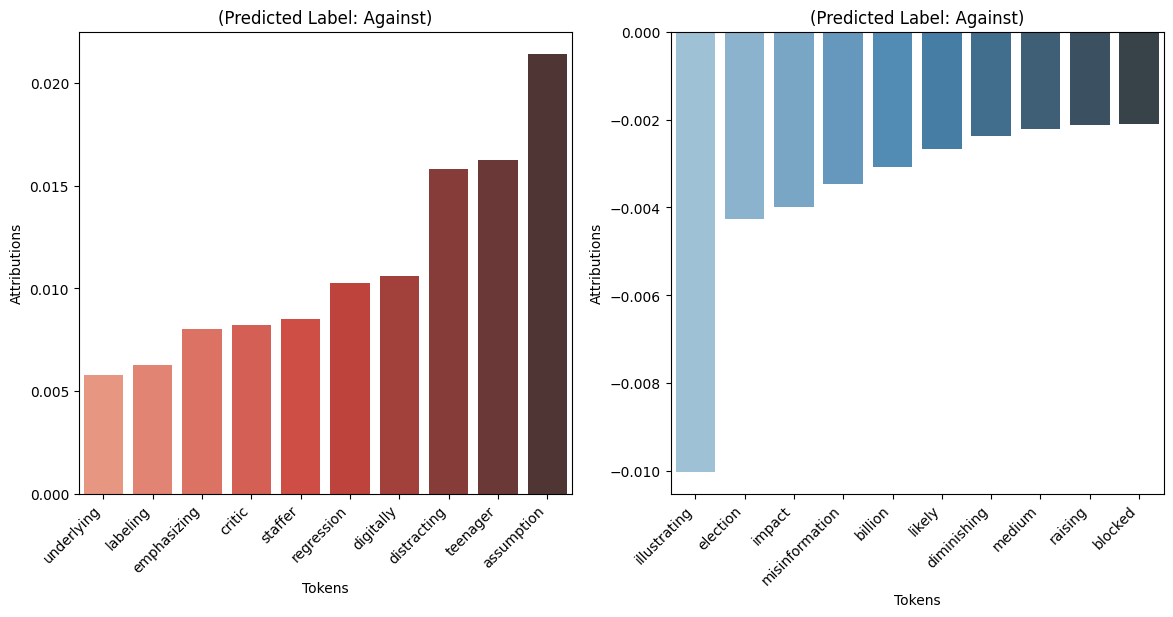

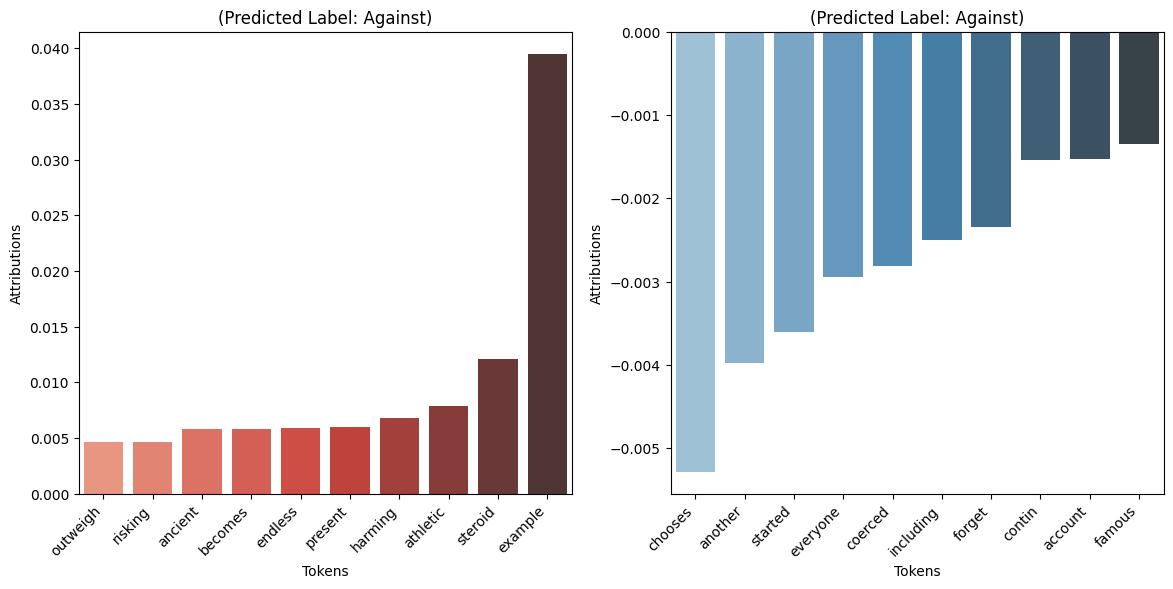

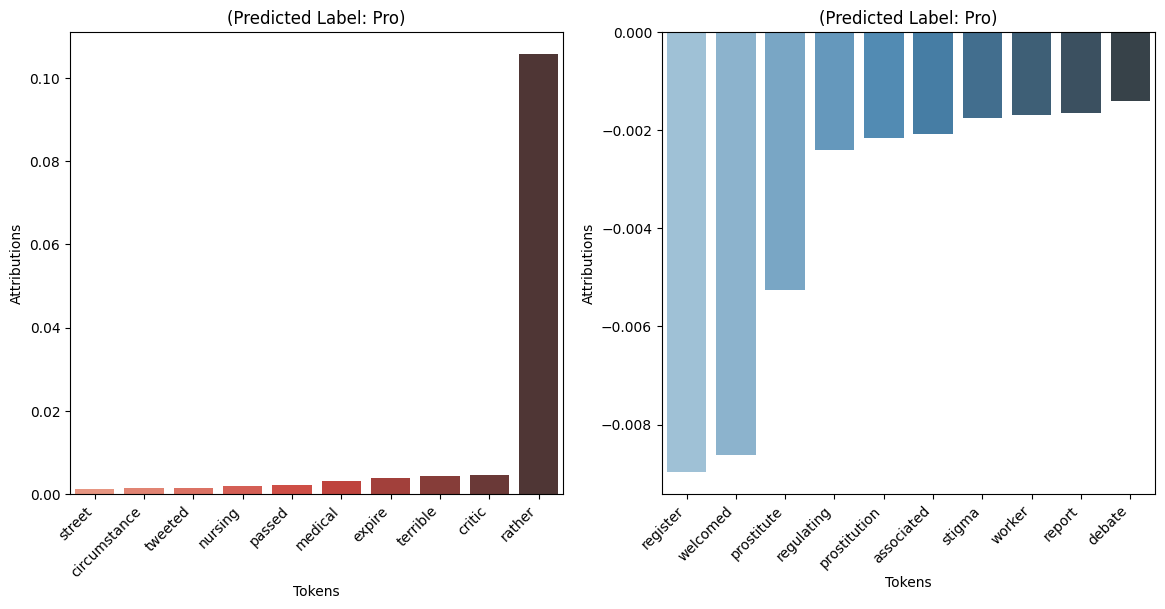

In [70]:
num_top_tokens = 10
num_bottom_tokens = 10


for i in range(example_input_ids.size(0)):
    #  original text
    print(f"Original Text for Example {i+1}:")
    print(bottom_examples['Input'].iloc[i])
    print("\n")
    
    # Get indices of tokens with highest and lowest attributions
    top_indices = np.argsort(filtered_attributions_cleaned[i])[-num_top_tokens:]
    bottom_indices = np.argsort(filtered_attributions_cleaned[i])[:num_bottom_tokens]

    # Select tokens and their corresponding attributions
    top_tokens = [filtered_tokens_cleaned[i][index] for index in top_indices]
    top_attributions = [filtered_attributions_cleaned[i][index] for index in top_indices]
    bottom_tokens = [filtered_tokens_cleaned[i][index] for index in bottom_indices]
    bottom_attributions = [filtered_attributions_cleaned[i][index] for index in bottom_indices]

    
    top_df = pd.DataFrame({
        'Token': top_tokens,
        'Attribution': top_attributions
    })

    bottom_df = pd.DataFrame({
        'Token': bottom_tokens,
        'Attribution': bottom_attributions
    })

   
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='Token', y='Attribution', data=top_df, palette='Reds_d')
    plt.xlabel('Tokens')
    plt.ylabel('Attributions')
    plt.title(f'(Predicted Label: {predicted_labels[i]})')
    plt.xticks(rotation=45, ha='right')

  
    plt.subplot(1, 2, 2)
    sns.barplot(x='Token', y='Attribution', data=bottom_df, palette='Blues_d')
    plt.xlabel('Tokens')
    plt.ylabel('Attributions')
    plt.title(f'(Predicted Label: {predicted_labels[i]})')
    plt.xticks(rotation=45, ha='right')
